In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay


In [4]:
df = pd.read_csv(r"c:\Users\vishwas.balkundi\Downloads\kaggledata\fraud_detection.csv")

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
print('Number of duplicates are : ', df.duplicated().sum())

Number of duplicates are :  0


In [8]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [9]:
df = df.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')

In [10]:
df

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


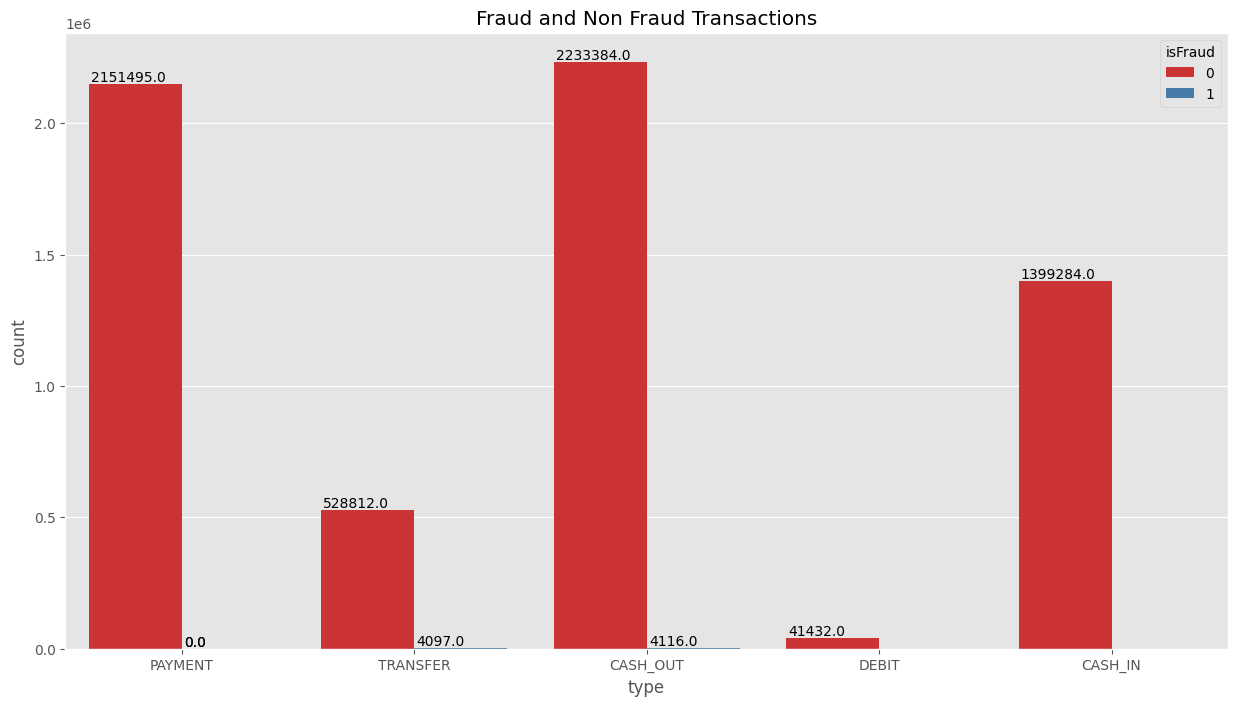

In [11]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = df, x = "type", hue="isFraud", palette = 'Set1')
plt.title('Fraud and Non Fraud Transactions')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

In [12]:
transfer_fraud = df[((df['type']=='TRANSFER') & df['isFraud']==1)]
transfer_fraud['nameOrig'].value_counts()

nameOrig
C1685995037    1
C1565612524    1
C992223106     1
C1945606464    1
C88849251      1
              ..
C669700766     1
C1364127192    1
C1334405552    1
C137533655     1
C1420196421    1
Name: count, Length: 4097, dtype: int64

In [13]:
cash_out_fraud = df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)]
cash_out_fraud['nameDest'].value_counts()

nameDest
C1601170327    2
C185805228     2
C2129197098    2
C643624257     2
C644163395     2
              ..
C922511709     1
C1626759869    1
C451934410     1
C256417920     1
C253690179     1
Name: count, Length: 4091, dtype: int64

In [14]:
data = df.copy()
data['type2'] = np.nan
data.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'), 'type2'] = 'CC'
data.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M'), 'type2'] = 'CM'
data.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'), 'type2'] = 'MC'
data.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'), 'type2'] = 'MM'

C:\Users\vishwas.balkundi\AppData\Local\Temp\ipykernel_17552\4129001006.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'), 'type2'] = 'CC'


In [15]:
data.drop(columns = ['nameOrig','nameDest'], axis = 'columns', inplace = True)

In [16]:
data.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type2
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,CM
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,CM
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,CC
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,CC
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,CM


In [17]:
fraud_trans = data[data['isFraud'] == 1]
valid_trans = data[data['isFraud'] == 0]

print('Number of fraud transactions according to type are below:\n', fraud_trans.type2.value_counts(), '\n')
print('Number of valid transactions according to type are below:\n', valid_trans.type2.value_counts())

Number of fraud transactions according to type are below:
 type2
CC    8213
Name: count, dtype: int64 

Number of valid transactions according to type are below:
 type2
CC    4202912
CM    2151495
Name: count, dtype: int64


In [18]:
fr = fraud_trans.type2.value_counts()
va = valid_trans.type2.value_counts()

Text(0.5, 1.0, 'Valid')

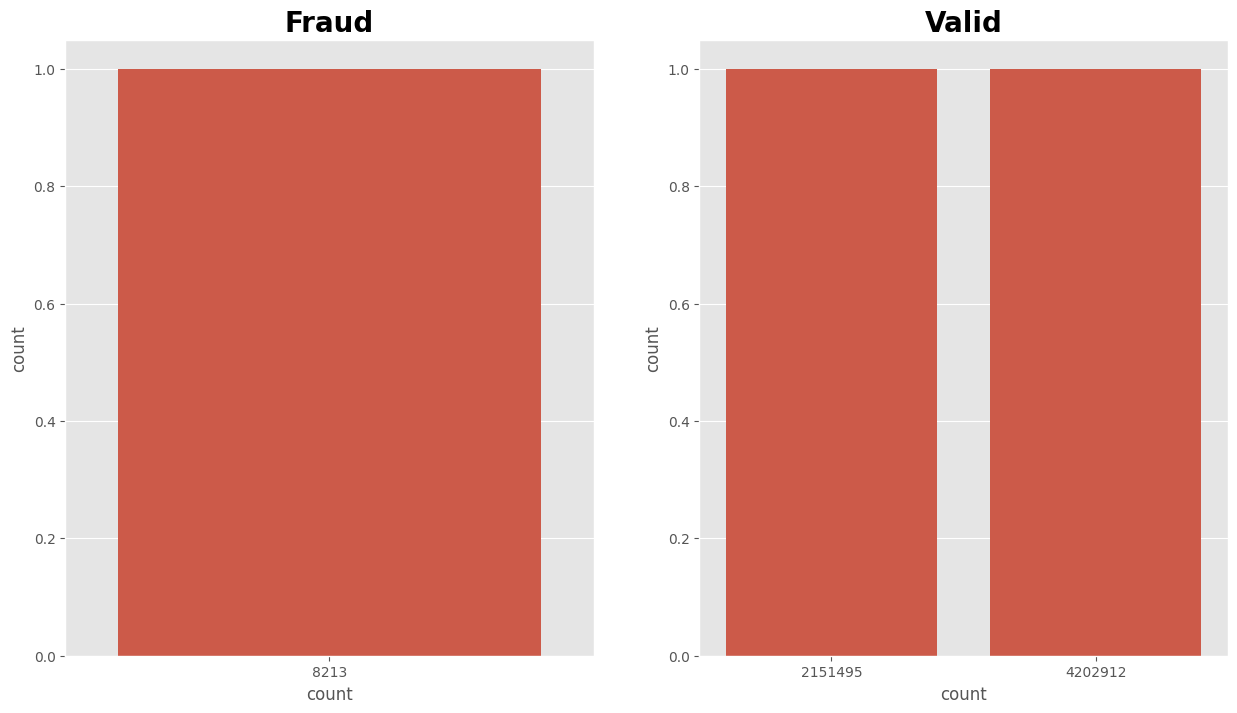

In [19]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.countplot(x = fr)
plt.title('Fraud',fontweight="bold", size=20)
plt.subplot(1,2,2)
sns.countplot(x = va)
plt.title('Valid',fontweight="bold", size=20)

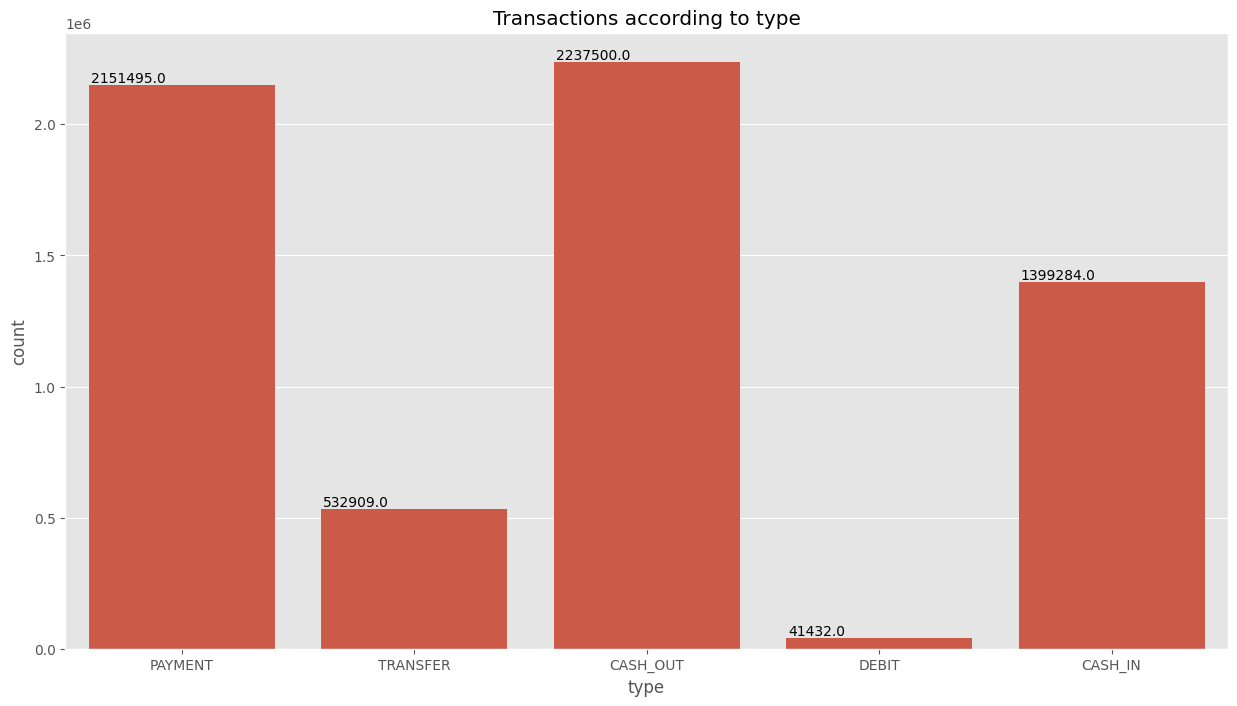

In [20]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type")
plt.title('Transactions according to type')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

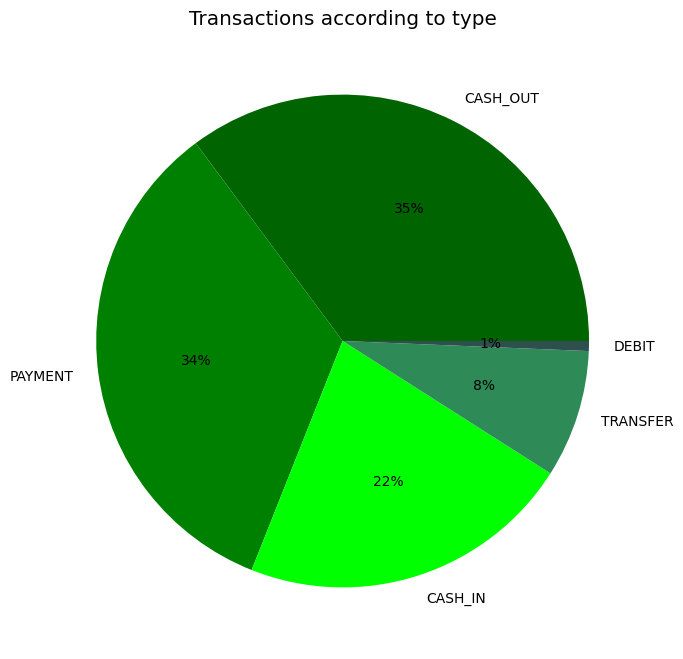

In [21]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000','#00FF00','#2E8B57','#2F4F4F']
plt.pie(data.type.value_counts().values,labels=data.type.value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("Transactions according to type")
plt.show()

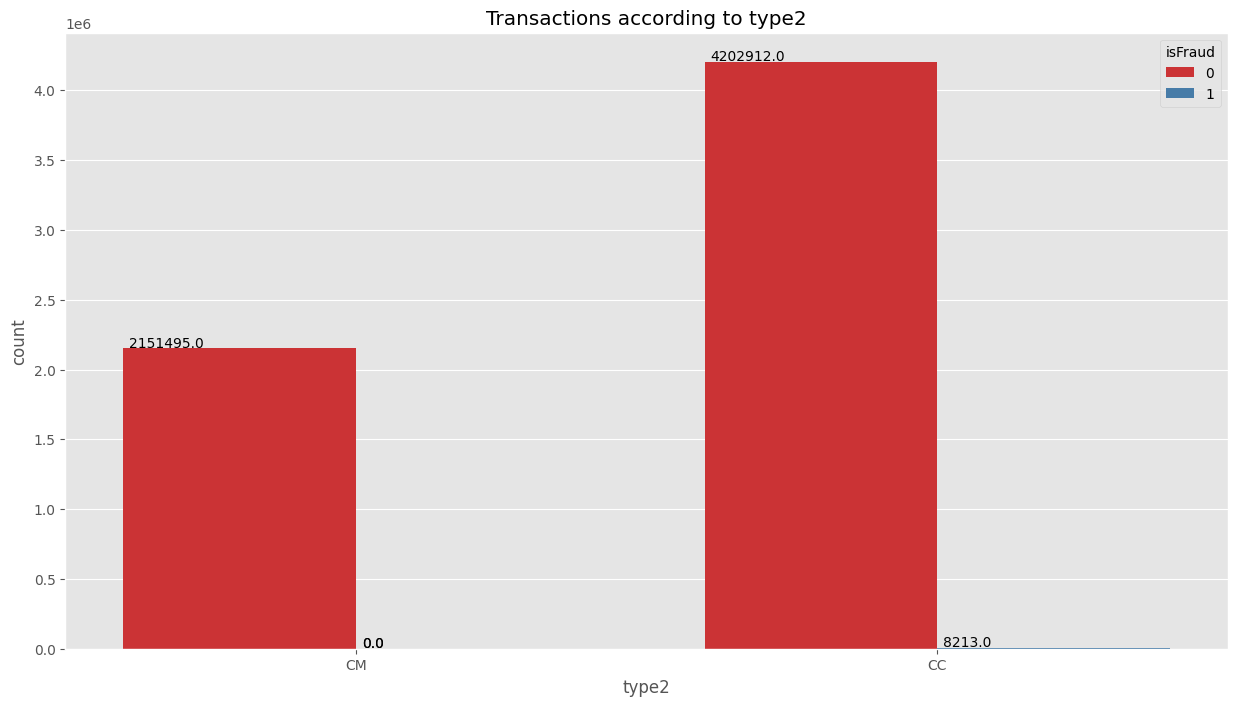

In [22]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type2", hue="isFraud", palette = 'Set1')
plt.title('Transactions according to type2')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

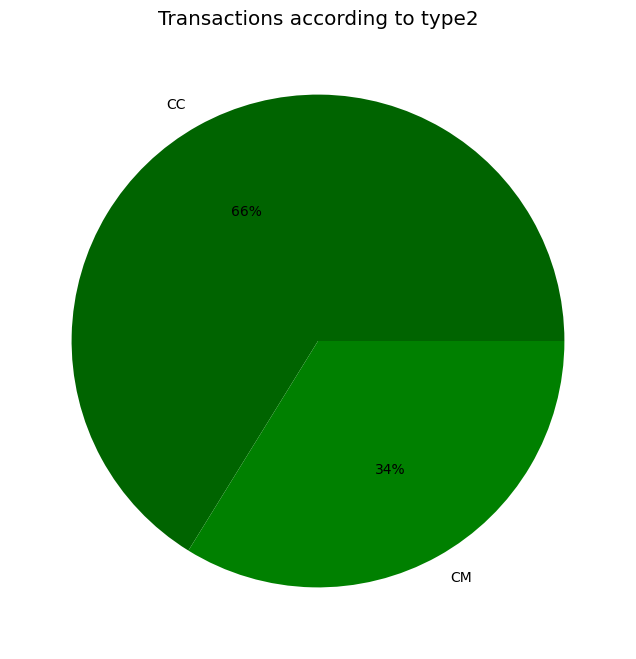

In [23]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000']
plt.pie(data.type2.value_counts().values,labels=data.type2.value_counts().index, colors = colors,  autopct='%.0f%%')
plt.title("Transactions according to type2")
plt.show()

In [24]:
data

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type2
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,CM
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,CM
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,CC
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,CC
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,CM
...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,CC
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,CC
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,CC
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,CC


In [25]:
# from scipy import stats
# z = np.abs(stats.zscore(data[data.dtypes[data.dtypes != 'object'].index]))
# perfect_df = data[(z < 3).all(axis=1)]

In [26]:
data = pd.get_dummies(data, prefix = ['type', 'type2'], drop_first = True)

In [27]:
data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CM
0,9839.64,170136.00,160296.36,0.00,0.00,0,False,False,True,False,True
1,1864.28,21249.00,19384.72,0.00,0.00,0,False,False,True,False,True
2,181.00,181.00,0.00,0.00,0.00,1,False,False,False,True,False
3,181.00,181.00,0.00,21182.00,0.00,1,True,False,False,False,False
4,11668.14,41554.00,29885.86,0.00,0.00,0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,1,True,False,False,False,False
6362616,6311409.28,6311409.28,0.00,0.00,0.00,1,False,False,False,True,False
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,True,False,False,False,False
6362618,850002.52,850002.52,0.00,0.00,0.00,1,False,False,False,True,False


In [28]:
X = data.drop('isFraud', axis=1)
y = data.isFraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = data.isFraud)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [29]:
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
xgbr = xgb.XGBClassifier(max_depth = 3, n_jobs = -1, random_state = 42, learning_rate = 0.1)

rfc.fit(X_train, y_train)
xgbr.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
y_pred_rfc = rfc.predict(X_test)
y_pred_xgbr = xgbr.predict(X_test)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

print(classification_report(y_test, y_pred_rfc))
print(confusion_matrix(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.97      0.79      0.87      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

[[1906256      66]
 [    522    1942]]


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

print(classification_report(y_test, y_pred_xgbr))
print(confusion_matrix(y_test,y_pred_xgbr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.71      0.83      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.86      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786

[[1906281      41]
 [    703    1761]]


In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [35]:
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train), 
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [36]:
def build_fraud_detection_model(input_dim):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryFocalCrossentropy(),  # Focal Loss for imbalance
        metrics=['accuracy', tf.keras.metrics.AUC(name="AUC")]
    )
    
    return model

# Get input dimension
input_dim = X_train.shape[1]

In [37]:
model = build_fraud_detection_model(input_dim)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=1024,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,  # Handling imbalance
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_AUC', patience=5, restore_best_weights=True)]
)


c:\Users\vishwas.balkundi\miniforge3\envs\env_ml\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - AUC: 0.9132 - accuracy: 0.8132 - loss: 0.1154 - val_AUC: 0.9873 - val_accuracy: 0.9109 - val_loss: 0.0502
Epoch 2/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - AUC: 0.9788 - accuracy: 0.9158 - loss: 0.0499 - val_AUC: 0.9886 - val_accuracy: 0.9522 - val_loss: 0.0355
Epoch 3/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 72s 16ms/step - AUC: 0.9860 - accuracy: 0.9304 - loss: 0.0404 - val_AUC: 0.9917 - val_accuracy: 0.8405 - val_loss: 0.0543
Epoch 4/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 78s 18ms/step - AUC: 0.9879 - accuracy: 0.9352 - loss: 0.0372 - val_AUC: 0.9952 - val_accuracy: 0.8820 - val_loss: 0.0533
Epoch 5/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 67s 15ms/step - AUC: 0.9908 - accuracy: 0.9400 - loss: 0.0325 - val_AUC: 0.9922 - val_accuracy: 0.8569 - val_loss: 0.0726
Epoch 6/50
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 74s 17ms/step - AUC: 0.9918 - accuracy: 0.9479 - loss: 0.0305 - val_AUC: 0.9951 - val_accuracy: 0.9655 - val_loss: 0.0211
Epoch 7/50
4350/

In [38]:
model.evaluate(X_test, y_test)


59650/59650 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - AUC: 0.9956 - accuracy: 0.8817 - loss: 0.0533


[0.05325227230787277, 0.8820056319236755, 0.9951698780059814]

In [39]:
y_pred_probs = model.predict(X_test) 
y_pred_neuralnets = (y_pred_probs > 0.5).astype(int)

59650/59650 ━━━━━━━━━━━━━━━━━━━━ 84s 1ms/step


In [40]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_neuralnets))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_neuralnets, digits=4))

# Compute AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_probs)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

Confusion Matrix:
[[1681110  225212]
 [     14    2450]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8819    0.9372   1906322
           1     0.0108    0.9943    0.0213      2464

    accuracy                         0.8820   1908786
   macro avg     0.5054    0.9381    0.4793   1908786
weighted avg     0.9987    0.8820    0.9360   1908786


AUC-ROC Score: 0.9952
